In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Loading Dataset

In [2]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query('select * from reviews limit 2000', conn)
    conn.close()
else:
    print('Please run Text Preprocessing code file')

In [3]:
# global variables
score = final['Score']
tsne_model = TSNE(n_components=2, random_state=0, perplexity=35, n_iter=5000)

# BOW t-sne representation

In [12]:
count_vect = CountVectorizer()
bow_sparse_matrix = count_vect.fit_transform(final['CleanedText'].values)
standardized_data = StandardScaler(with_mean=False).fit_transform(bow_sparse_matrix) # column standardizing sparse matrix
tsne_data = tsne_model.fit_transform(standardized_data.toarray())
tsne_data

array([[-16.439651  ,  -2.0023468 ],
       [-78.5174    , 192.71655   ],
       [ -8.296562  ,   0.34307697],
       ...,
       [ 10.184989  ,  -5.932878  ],
       [ -8.245834  ,   3.4641194 ],
       [  3.6314452 , -13.322049  ]], dtype=float32)

In [16]:
print(type(tsne_data))
tsne_data.shape

<class 'numpy.ndarray'>


(2000, 2)

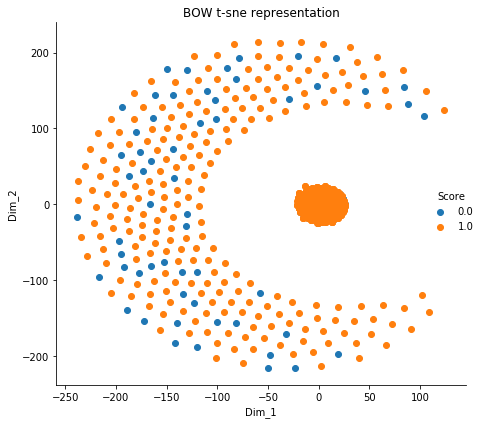

In [23]:
tsne_data = np.vstack((tsne_data.T, score)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'Score'))
sns.FacetGrid(tsne_df, hue='Score', size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('BOW t-sne representation')
plt.tight_layout()

# Tfidf t-sne representation

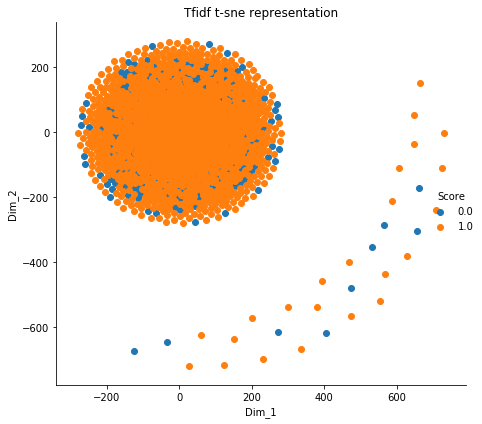

In [4]:
tfidf_vect = TfidfVectorizer(ngram_range = (1,2))
tfidf_sparse_matrix = tfidf_vect.fit_transform(final['CleanedText'].values)
standardized_data = StandardScaler(with_mean=False).fit_transform(tfidf_sparse_matrix)
tsne_data = tsne_model.fit_transform(standardized_data.toarray())
tsne_data = np.vstack((tsne_data.T, score)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'Score'))
sns.FacetGrid(tsne_df, hue='Score', size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Tfidf t-sne representation')
plt.tight_layout()

# AvgW2Vec t-sne representation

In [4]:
list_of_sentences = []
for sentence in final['CleanedText'].values:
    list_of_sentences.append(sentence.split())

In [7]:
w2v_model = Word2Vec(list_of_sentences, min_count=3, vector_size=60, workers=4)
w2v_words = list(w2v_model.wv.index_to_key)

In [10]:
sentence_vectors = []
for sentence in tqdm(list_of_sentences):
    sentence_vector = np.zeros(60)
    count_words = 0
    for word in sentence:
        if word in w2v_words:
            word_vector = w2v_model.wv[word]
            sentence_vector += word_vector
            count_words += 1
    if count_words != 0:
        sentence_vector /= count_words
    sentence_vectors.append(sentence_vector)

100%|██████████| 2000/2000 [00:00<00:00, 2300.78it/s]


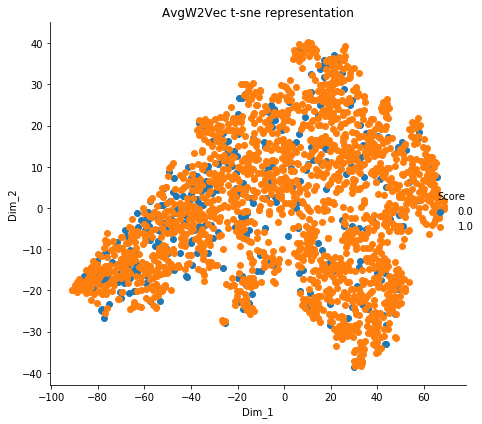

In [11]:
standardized_data = StandardScaler().fit_transform(sentence_vectors)
tsne_data = tsne_model.fit_transform(standardized_data)
tsne_data = np.vstack((tsne_data.T, score)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', "Score"))
sns.FacetGrid(tsne_df, hue='Score', size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('AvgW2Vec t-sne representation')
plt.tight_layout()